# Restricted Boltzmann Machine - MNIST

## Imports

In [1]:
import sys, datetime
import os

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

## Load data

In [3]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
#print(X_original.shape)

## Parameters

In [4]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3 ###########SEE Pdf
# use (+1,-1) if SPINS, otherwise use bits (1,0), ising spins
SPINS=False  
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False


dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L  # Possible configurations(?)
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('7', '8', '9')
dataset with 21076 points, each with 784 bits

first 10 MNIST data points


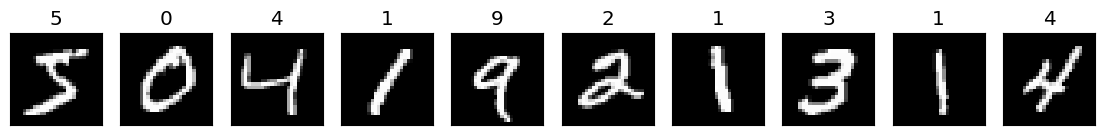

first 10 MNIST-3 data points


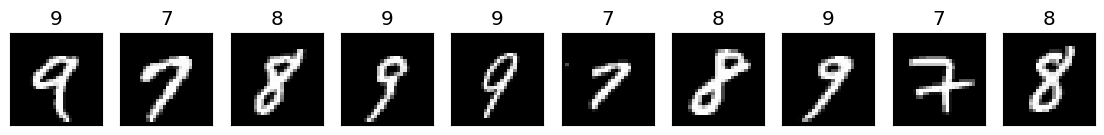

first 10 MNIST-3 data points, binarized


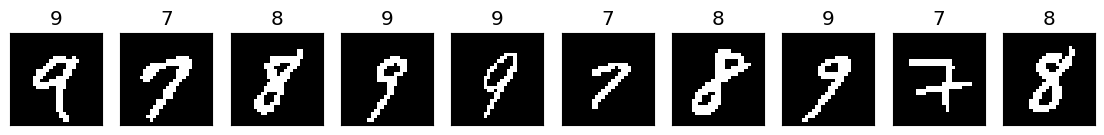

each of Nd=21076 data has D=784 bits


In [5]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[], save=False):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "grey"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")
    plt.show()

def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")


# Selecting digits to use
list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[-Ndigit:] ########to fine grain set digits  CHOSEN  7-8-9
print(list_digits)

# keep only X and Y in list_digitssssssssss
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]


data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units - I.e. total pixels of the image
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

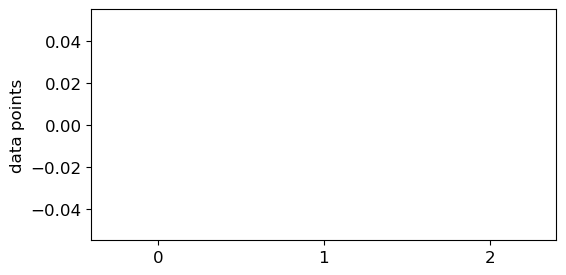

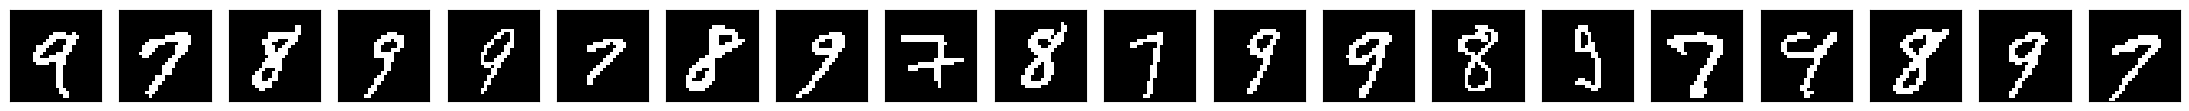

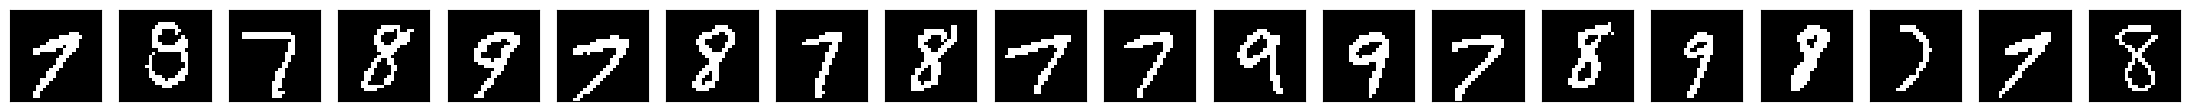

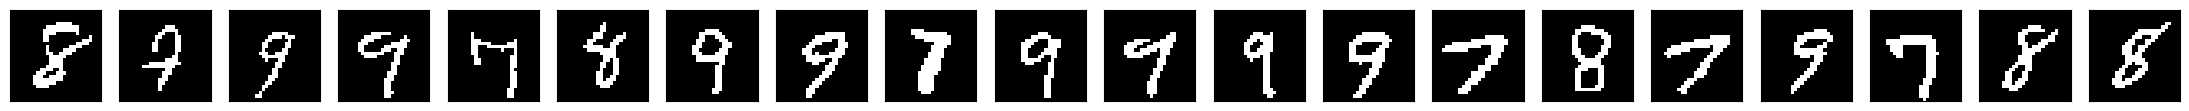

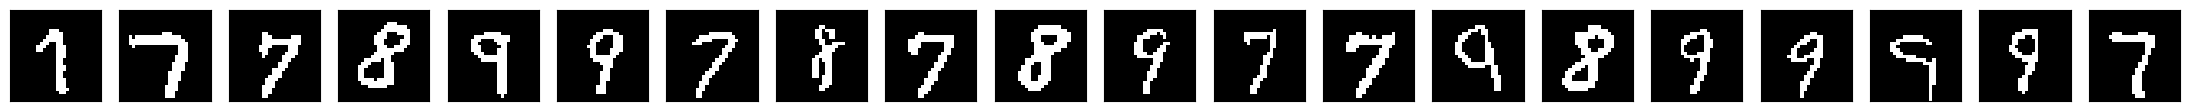

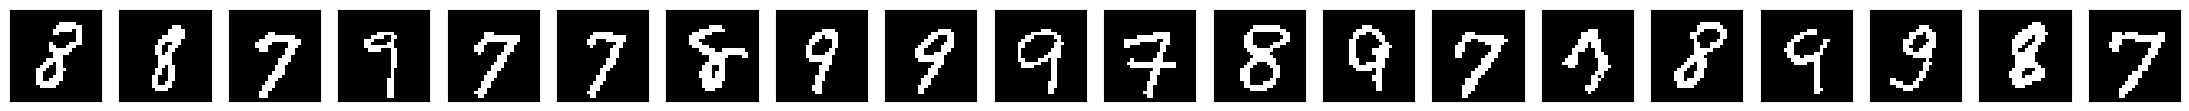

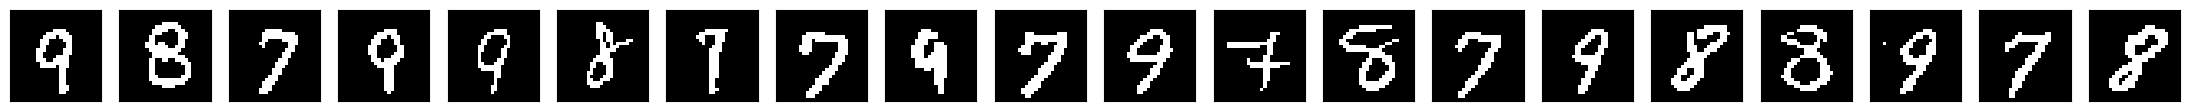

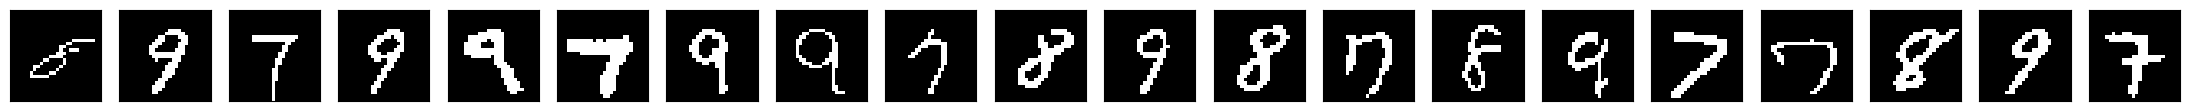

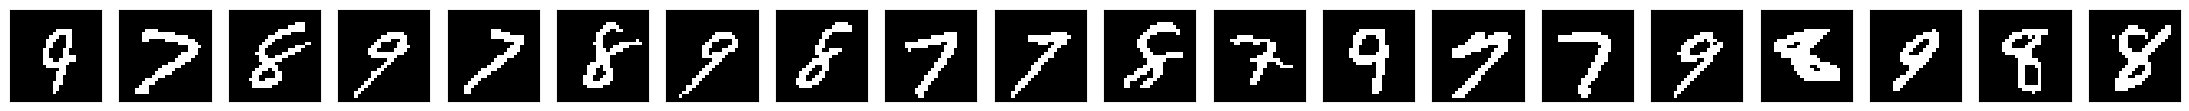

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")#np.sort(label)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [7]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
#@jit(parallel=True)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    
    # H is b + v*w
    H = np.clip(np.dot(v_in.astype(np.float64), wei) + bias, a_min=-300, a_max=300)
    # "activation" note, it is a sigmoid freud
    a = np.exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        
        # Probability of turning on a hidden unit
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]:
            i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return (v_out,p,a)
    else: return v_out

## Plot weights

In [8]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [9]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    '''
    x ::shape of 'x'(data): (21770,784)
    xmean :: does the mean on 'data' for each column -> shape of xmean :(,784)
     xmin =0, xmax=1 if SPINS=FALSE, otherwise {-1,+1}
    since np.precision is set at 4 -> S = 1e-4
    level_gap :: is the difference in values between the max (1) and the min (x_min)
    np.clip :: avoid minimum maximum overflow, inf and -inf values.
    '''
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S 
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## Gradient descent method

In [10]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


### Log-Likelihood

In [11]:
import numpy as np
import itertools as it

#This code has been optimized with the help of chatGPT 4o. It is now clear the importance of using numpy array instead of lists when dealing with repeated operations, and that appending to a vector is 
# not optimized, instead is better to initialize a scalar and accumulate to it. Also important to do all possible operations outside of loops.
#@jit(parallel=True)
def generate_configurations(L):
    """Generate all binary configurations of length L."""
    return np.array(list(it.product((0,1), repeat=L)), dtype=np.int64)
#@jit(parallel=True)
def compute_log_likelihood(partition,data, a, b, w):
    log_likelihoods = np.zeros(len(data))  # Preallocate array
    all_conf = generate_configurations(L)  # Compute binary configs once

    Hz_cache = np.array([H(z) for z in all_conf])  # Precompute H(z)

    for i, x in enumerate(data): 
        Z_x = 0.0
        for Hz, z in zip(Hz_cache, all_conf):
            E_xz = -np.dot(Hz, x) - np.dot(b, z)
            Z_x += np.exp(-E_xz)

        log_likelihoods[i] = np.clip(np.log(Z_x) - partition, a_min=-700, a_max=+7000)

    return np.mean(log_likelihoods)

def H(z):  
    return a + np.dot(w, z)  

def G(z):  
    return np.prod(np.exp(b * z))
#@jit(parallel=True)

#@jit(forceobj=True, looplift=True)
def partition_function(configurations):
    #all_conf = generate_configurations(L)
    sum_values = 0.0  # Use scalar accumulation

    for z in configurations:
        Hz = H(z)
        produttoria_H = np.prod(1 + np.exp(Hz))
        sum_values += G(z) * produttoria_H

    return np.log(sum_values)





# CV

In [24]:
import time
## Hyper parameters::

L = 5
print(f'L, hidden units: {L}')
SPINS = False#np.random.choice([True, False])
print(f'SPINS: {SPINS}')
POTTS = False
print(f'POTTS: {POTTS}')
gamma = .001
print(f'gamma: {gamma}')
GRAD = 'SGD'
print(f'GRAD: {GRAD}')
Nt = 2
print(f'Nt: {Nt}')
Nepoch = 190
print(f'Epochs: {Nepoch}')
Nmini = 45
print(f'Nmini: {Nmini}')
N_ini = 10
print(f'Nini: {N_ini}')
N_fin = 450
print(f'Nfin: {N_fin}')


## Prof. setup for gradient choice & gamma
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

## Prof setup for spin/potts/other thing

if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")


stringa = f'#L SPIN POTTS gamma Nt Nepoch Nmini Nini Nfin Grad'
stringa2 = [L, SPINS, POTTS, gamma, Nt, Nepoch, Nmini, N_ini, N_fin, GRAD]
with open(f'llh{int((code := time.time()))}.txt', 'a') as add:
    print(stringa, file=add)
    print(stringa2, file=add)
    

L, hidden units: 5
SPINS: False
POTTS: False
gamma: 0.001
GRAD: SGD
Nt: 2
Epochs: 190
Nmini: 45
Nini: 10
Nfin: 450
D=784	sample size
L=5	nr. z states
Gradient descent type: SGD
learning rate        = 1.0 --> 0.25
gamma=0.001	regularization


## CV reale

Nepoch=190
Nmini=45


<Figure size 640x480 with 0 Axes>

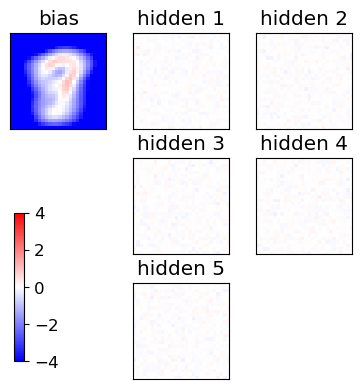

Starting the training
[12985 10720 11169 16599 11958 12574   543 11101  9686  7362]
[11739 15994 14818 13433 15240 19994  7693  4858 19383  8275]
[ 1413  4394 19397 20840 14462  9038 11009 19059 12571 11584]
[  861 17096  7120  8472  3963 11749  3190 18089 15221   217]
epoch 1 / 190  Nt: 2  N: 10  L: 5  rate: 1.0  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 190  Nt: 2  N: 10  L: 5  rate: 0.996031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 190  Nt: 2  N: 10  L: 5  rate: 0.9920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 190  Nt: 2  N: 10  L: 5  rate: 0.9880952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 190  Nt: 2  N: 10  L: 5  rate: 0.9841269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 190  Nt: 2  N: 10  L: 5  rate: 0.9801587301587301  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 190  Nt: 2  N: 10  L: 5  rate: 0.9761904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 190  Nt: 2  N: 10  L: 5  rate: 0.9722222222222222 

<Figure size 640x480 with 0 Axes>

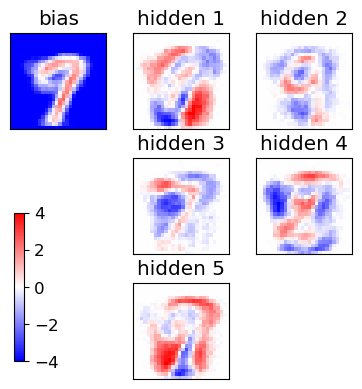

epoch 21 / 190  Nt: 2  N: 14  L: 5  rate: 0.9206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 190  Nt: 2  N: 15  L: 5  rate: 0.9166666666666666  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 190  Nt: 2  N: 15  L: 5  rate: 0.9126984126984127  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 190  Nt: 2  N: 16  L: 5  rate: 0.9087301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 190  Nt: 2  N: 17  L: 5  rate: 0.9047619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 190  Nt: 2  N: 17  L: 5  rate: 0.9007936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 190  Nt: 2  N: 18  L: 5  rate: 0.8968253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 190  Nt: 2  N: 18  L: 5  rate: 0.8928571428571429  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 190  Nt: 2  N: 19  L: 5  rate: 0.8888888888888888  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 190  Nt: 2  N: 20  L: 5  rate: 0.8849206349206349  gam: 0.001 SPINS= False POTTS= False
epoch 31 /

<Figure size 640x480 with 0 Axes>

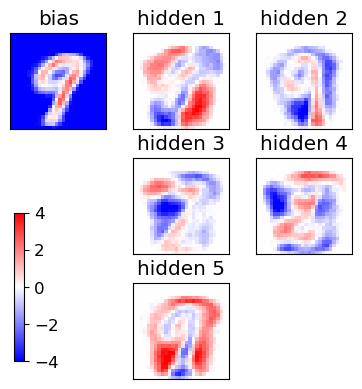

epoch 41 / 190  Nt: 2  N: 29  L: 5  rate: 0.8412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 190  Nt: 2  N: 30  L: 5  rate: 0.8373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 190  Nt: 2  N: 31  L: 5  rate: 0.8333333333333334  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 190  Nt: 2  N: 32  L: 5  rate: 0.8293650793650793  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 190  Nt: 2  N: 33  L: 5  rate: 0.8253968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 190  Nt: 2  N: 34  L: 5  rate: 0.8214285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 190  Nt: 2  N: 36  L: 5  rate: 0.8174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 190  Nt: 2  N: 37  L: 5  rate: 0.8134920634920635  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 190  Nt: 2  N: 38  L: 5  rate: 0.8095238095238095  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 190  Nt: 2  N: 39  L: 5  rate: 0.8055555555555556  gam: 0.001 SPINS= False POTTS= False
epoch 51 /

<Figure size 640x480 with 0 Axes>

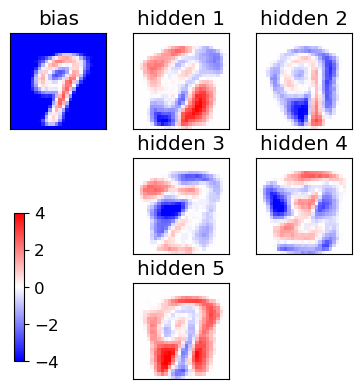

epoch 61 / 190  Nt: 2  N: 54  L: 5  rate: 0.7619047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 190  Nt: 2  N: 55  L: 5  rate: 0.7579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 190  Nt: 2  N: 57  L: 5  rate: 0.753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 190  Nt: 2  N: 58  L: 5  rate: 0.75  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 190  Nt: 2  N: 60  L: 5  rate: 0.746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 190  Nt: 2  N: 62  L: 5  rate: 0.7420634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 190  Nt: 2  N: 63  L: 5  rate: 0.7380952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 190  Nt: 2  N: 65  L: 5  rate: 0.7341269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 190  Nt: 2  N: 66  L: 5  rate: 0.7301587301587302  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 190  Nt: 2  N: 68  L: 5  rate: 0.7261904761904763  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 190  Nt: 2  N: 

<Figure size 640x480 with 0 Axes>

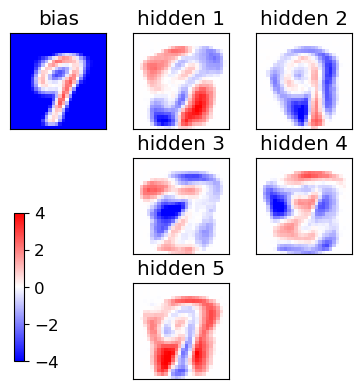

epoch 81 / 190  Nt: 2  N: 88  L: 5  rate: 0.6825396825396826  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 190  Nt: 2  N: 90  L: 5  rate: 0.6785714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 190  Nt: 2  N: 92  L: 5  rate: 0.6746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 190  Nt: 2  N: 94  L: 5  rate: 0.6706349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 190  Nt: 2  N: 96  L: 5  rate: 0.6666666666666667  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 190  Nt: 2  N: 98  L: 5  rate: 0.6626984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 190  Nt: 2  N: 101  L: 5  rate: 0.6587301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 190  Nt: 2  N: 103  L: 5  rate: 0.6547619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 190  Nt: 2  N: 105  L: 5  rate: 0.6507936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 190  Nt: 2  N: 107  L: 5  rate: 0.6468253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 

<Figure size 640x480 with 0 Axes>

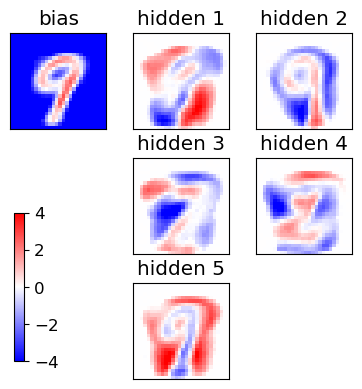

epoch 101 / 190  Nt: 2  N: 133  L: 5  rate: 0.6031746031746033  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 190  Nt: 2  N: 135  L: 5  rate: 0.5992063492063492  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 190  Nt: 2  N: 138  L: 5  rate: 0.5952380952380952  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 190  Nt: 2  N: 140  L: 5  rate: 0.5912698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 190  Nt: 2  N: 143  L: 5  rate: 0.5873015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 190  Nt: 2  N: 145  L: 5  rate: 0.5833333333333333  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 190  Nt: 2  N: 148  L: 5  rate: 0.5793650793650794  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 190  Nt: 2  N: 151  L: 5  rate: 0.5753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 190  Nt: 2  N: 153  L: 5  rate: 0.5714285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 190  Nt: 2  N: 156  L: 5  rate: 0.5674603174603174  gam: 0.001 SPINS= False POT

<Figure size 640x480 with 0 Axes>

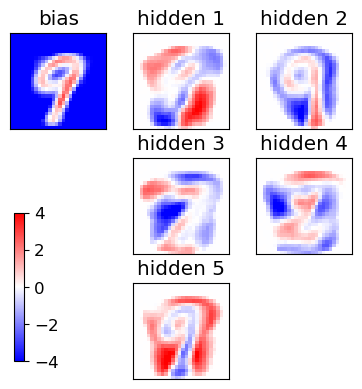

epoch 121 / 190  Nt: 2  N: 187  L: 5  rate: 0.5238095238095238  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 190  Nt: 2  N: 190  L: 5  rate: 0.5198412698412698  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 190  Nt: 2  N: 193  L: 5  rate: 0.5158730158730159  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 190  Nt: 2  N: 196  L: 5  rate: 0.5119047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 190  Nt: 2  N: 199  L: 5  rate: 0.5079365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 190  Nt: 2  N: 202  L: 5  rate: 0.503968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 190  Nt: 2  N: 205  L: 5  rate: 0.5  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 190  Nt: 2  N: 208  L: 5  rate: 0.49603174603174605  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 190  Nt: 2  N: 211  L: 5  rate: 0.4920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 190  Nt: 2  N: 214  L: 5  rate: 0.48809523809523814  gam: 0.001 SPINS= False POTTS= False
epoc

<Figure size 640x480 with 0 Axes>

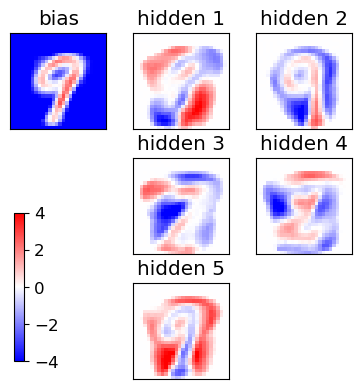

epoch 141 / 190  Nt: 2  N: 251  L: 5  rate: 0.4444444444444444  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 190  Nt: 2  N: 254  L: 5  rate: 0.44047619047619047  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 190  Nt: 2  N: 258  L: 5  rate: 0.4365079365079365  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 190  Nt: 2  N: 261  L: 5  rate: 0.43253968253968256  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 190  Nt: 2  N: 265  L: 5  rate: 0.4285714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 190  Nt: 2  N: 268  L: 5  rate: 0.42460317460317465  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 190  Nt: 2  N: 272  L: 5  rate: 0.4206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 190  Nt: 2  N: 276  L: 5  rate: 0.41666666666666663  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 190  Nt: 2  N: 279  L: 5  rate: 0.4126984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 190  Nt: 2  N: 283  L: 5  rate: 0.4087301587301587  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

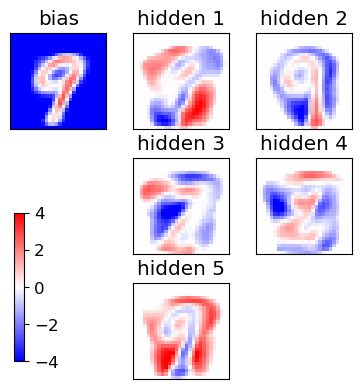

epoch 161 / 190  Nt: 2  N: 325  L: 5  rate: 0.3650793650793651  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 190  Nt: 2  N: 329  L: 5  rate: 0.36111111111111116  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 190  Nt: 2  N: 333  L: 5  rate: 0.3571428571428572  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 190  Nt: 2  N: 337  L: 5  rate: 0.35317460317460314  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 190  Nt: 2  N: 341  L: 5  rate: 0.3492063492063493  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 190  Nt: 2  N: 345  L: 5  rate: 0.34523809523809523  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 190  Nt: 2  N: 349  L: 5  rate: 0.3412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 190  Nt: 2  N: 353  L: 5  rate: 0.3373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 190  Nt: 2  N: 357  L: 5  rate: 0.33333333333333337  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 190  Nt: 2  N: 361  L: 5  rate: 0.3293650793650793  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

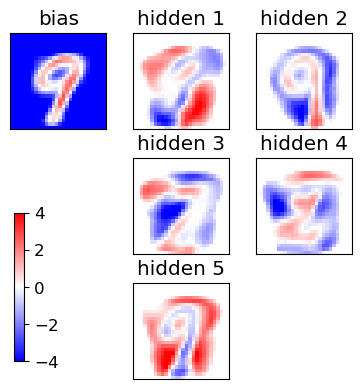

epoch 181 / 190  Nt: 2  N: 409  L: 5  rate: 0.2857142857142858  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 190  Nt: 2  N: 413  L: 5  rate: 0.28174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 190  Nt: 2  N: 418  L: 5  rate: 0.2777777777777778  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 190  Nt: 2  N: 422  L: 5  rate: 0.27380952380952384  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 190  Nt: 2  N: 427  L: 5  rate: 0.2698412698412699  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 190  Nt: 2  N: 431  L: 5  rate: 0.2658730158730158  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 190  Nt: 2  N: 436  L: 5  rate: 0.261904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 190  Nt: 2  N: 440  L: 5  rate: 0.2579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 190  Nt: 2  N: 445  L: 5  rate: 0.25396825396825395  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 190  Nt: 2  N: 450  L: 5  rate: 0.25  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

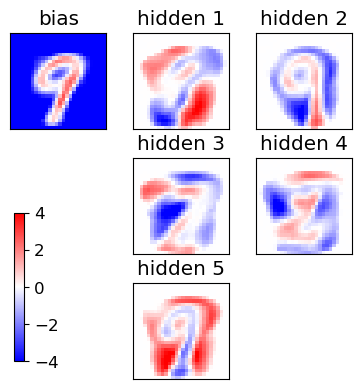

END of learning phase
Nepoch=190
Nmini=45


<Figure size 640x480 with 0 Axes>

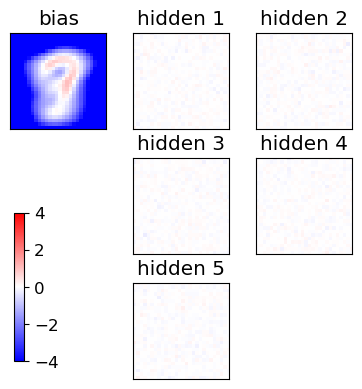

Starting the training
[ 3152 12237 20263 19748  1516 19712   257 15690 16824 19853]
[ 2327 16747  7561  6400  5882  8977 12281 10457 11529 17721]
[ 9493 19390 19368 17492 17363 10706  7368 18217 20178  9149]
[17632  7555  1873  2330 19569 18520 16454  2581 15590  8365]
epoch 1 / 190  Nt: 2  N: 10  L: 5  rate: 1.0  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 190  Nt: 2  N: 10  L: 5  rate: 0.996031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 190  Nt: 2  N: 10  L: 5  rate: 0.9920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 190  Nt: 2  N: 10  L: 5  rate: 0.9880952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 190  Nt: 2  N: 10  L: 5  rate: 0.9841269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 190  Nt: 2  N: 10  L: 5  rate: 0.9801587301587301  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 190  Nt: 2  N: 10  L: 5  rate: 0.9761904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 190  Nt: 2  N: 10  L: 5  rate: 0.9722222222222222 

<Figure size 640x480 with 0 Axes>

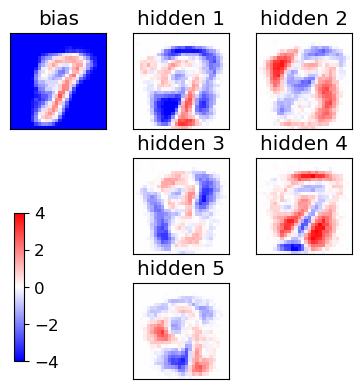

epoch 21 / 190  Nt: 2  N: 14  L: 5  rate: 0.9206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 190  Nt: 2  N: 15  L: 5  rate: 0.9166666666666666  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 190  Nt: 2  N: 15  L: 5  rate: 0.9126984126984127  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 190  Nt: 2  N: 16  L: 5  rate: 0.9087301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 190  Nt: 2  N: 17  L: 5  rate: 0.9047619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 190  Nt: 2  N: 17  L: 5  rate: 0.9007936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 190  Nt: 2  N: 18  L: 5  rate: 0.8968253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 190  Nt: 2  N: 18  L: 5  rate: 0.8928571428571429  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 190  Nt: 2  N: 19  L: 5  rate: 0.8888888888888888  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 190  Nt: 2  N: 20  L: 5  rate: 0.8849206349206349  gam: 0.001 SPINS= False POTTS= False
epoch 31 /

<Figure size 640x480 with 0 Axes>

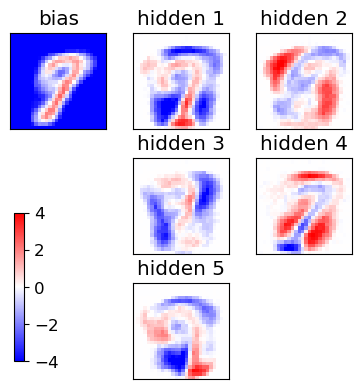

epoch 41 / 190  Nt: 2  N: 29  L: 5  rate: 0.8412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 190  Nt: 2  N: 30  L: 5  rate: 0.8373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 190  Nt: 2  N: 31  L: 5  rate: 0.8333333333333334  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 190  Nt: 2  N: 32  L: 5  rate: 0.8293650793650793  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 190  Nt: 2  N: 33  L: 5  rate: 0.8253968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 190  Nt: 2  N: 34  L: 5  rate: 0.8214285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 190  Nt: 2  N: 36  L: 5  rate: 0.8174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 190  Nt: 2  N: 37  L: 5  rate: 0.8134920634920635  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 190  Nt: 2  N: 38  L: 5  rate: 0.8095238095238095  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 190  Nt: 2  N: 39  L: 5  rate: 0.8055555555555556  gam: 0.001 SPINS= False POTTS= False
epoch 51 /

<Figure size 640x480 with 0 Axes>

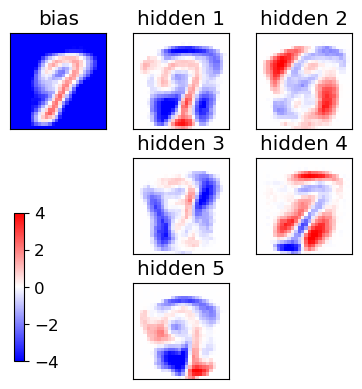

epoch 61 / 190  Nt: 2  N: 54  L: 5  rate: 0.7619047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 190  Nt: 2  N: 55  L: 5  rate: 0.7579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 190  Nt: 2  N: 57  L: 5  rate: 0.753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 190  Nt: 2  N: 58  L: 5  rate: 0.75  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 190  Nt: 2  N: 60  L: 5  rate: 0.746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 190  Nt: 2  N: 62  L: 5  rate: 0.7420634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 190  Nt: 2  N: 63  L: 5  rate: 0.7380952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 190  Nt: 2  N: 65  L: 5  rate: 0.7341269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 190  Nt: 2  N: 66  L: 5  rate: 0.7301587301587302  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 190  Nt: 2  N: 68  L: 5  rate: 0.7261904761904763  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 190  Nt: 2  N: 

<Figure size 640x480 with 0 Axes>

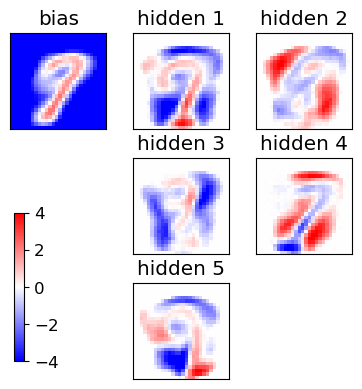

epoch 81 / 190  Nt: 2  N: 88  L: 5  rate: 0.6825396825396826  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 190  Nt: 2  N: 90  L: 5  rate: 0.6785714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 190  Nt: 2  N: 92  L: 5  rate: 0.6746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 190  Nt: 2  N: 94  L: 5  rate: 0.6706349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 190  Nt: 2  N: 96  L: 5  rate: 0.6666666666666667  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 190  Nt: 2  N: 98  L: 5  rate: 0.6626984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 190  Nt: 2  N: 101  L: 5  rate: 0.6587301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 190  Nt: 2  N: 103  L: 5  rate: 0.6547619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 190  Nt: 2  N: 105  L: 5  rate: 0.6507936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 190  Nt: 2  N: 107  L: 5  rate: 0.6468253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 

<Figure size 640x480 with 0 Axes>

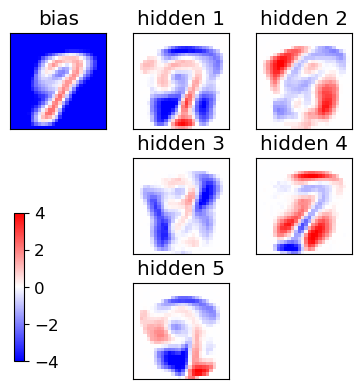

epoch 101 / 190  Nt: 2  N: 133  L: 5  rate: 0.6031746031746033  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 190  Nt: 2  N: 135  L: 5  rate: 0.5992063492063492  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 190  Nt: 2  N: 138  L: 5  rate: 0.5952380952380952  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 190  Nt: 2  N: 140  L: 5  rate: 0.5912698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 190  Nt: 2  N: 143  L: 5  rate: 0.5873015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 190  Nt: 2  N: 145  L: 5  rate: 0.5833333333333333  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 190  Nt: 2  N: 148  L: 5  rate: 0.5793650793650794  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 190  Nt: 2  N: 151  L: 5  rate: 0.5753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 190  Nt: 2  N: 153  L: 5  rate: 0.5714285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 190  Nt: 2  N: 156  L: 5  rate: 0.5674603174603174  gam: 0.001 SPINS= False POT

<Figure size 640x480 with 0 Axes>

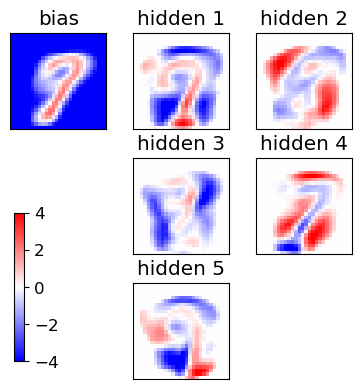

epoch 121 / 190  Nt: 2  N: 187  L: 5  rate: 0.5238095238095238  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 190  Nt: 2  N: 190  L: 5  rate: 0.5198412698412698  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 190  Nt: 2  N: 193  L: 5  rate: 0.5158730158730159  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 190  Nt: 2  N: 196  L: 5  rate: 0.5119047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 190  Nt: 2  N: 199  L: 5  rate: 0.5079365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 190  Nt: 2  N: 202  L: 5  rate: 0.503968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 190  Nt: 2  N: 205  L: 5  rate: 0.5  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 190  Nt: 2  N: 208  L: 5  rate: 0.49603174603174605  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 190  Nt: 2  N: 211  L: 5  rate: 0.4920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 190  Nt: 2  N: 214  L: 5  rate: 0.48809523809523814  gam: 0.001 SPINS= False POTTS= False
epoc

<Figure size 640x480 with 0 Axes>

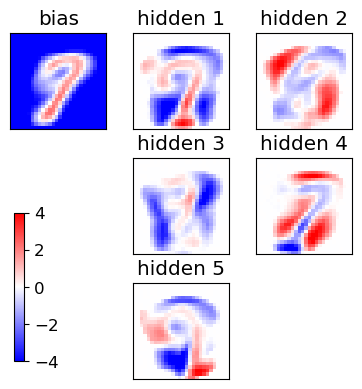

epoch 141 / 190  Nt: 2  N: 251  L: 5  rate: 0.4444444444444444  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 190  Nt: 2  N: 254  L: 5  rate: 0.44047619047619047  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 190  Nt: 2  N: 258  L: 5  rate: 0.4365079365079365  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 190  Nt: 2  N: 261  L: 5  rate: 0.43253968253968256  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 190  Nt: 2  N: 265  L: 5  rate: 0.4285714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 190  Nt: 2  N: 268  L: 5  rate: 0.42460317460317465  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 190  Nt: 2  N: 272  L: 5  rate: 0.4206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 190  Nt: 2  N: 276  L: 5  rate: 0.41666666666666663  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 190  Nt: 2  N: 279  L: 5  rate: 0.4126984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 190  Nt: 2  N: 283  L: 5  rate: 0.4087301587301587  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

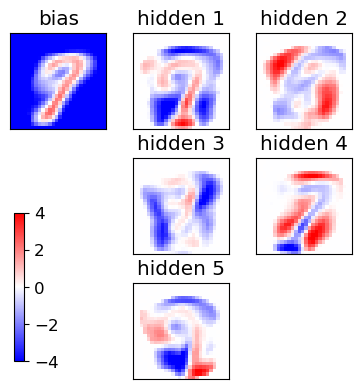

epoch 161 / 190  Nt: 2  N: 325  L: 5  rate: 0.3650793650793651  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 190  Nt: 2  N: 329  L: 5  rate: 0.36111111111111116  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 190  Nt: 2  N: 333  L: 5  rate: 0.3571428571428572  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 190  Nt: 2  N: 337  L: 5  rate: 0.35317460317460314  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 190  Nt: 2  N: 341  L: 5  rate: 0.3492063492063493  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 190  Nt: 2  N: 345  L: 5  rate: 0.34523809523809523  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 190  Nt: 2  N: 349  L: 5  rate: 0.3412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 190  Nt: 2  N: 353  L: 5  rate: 0.3373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 190  Nt: 2  N: 357  L: 5  rate: 0.33333333333333337  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 190  Nt: 2  N: 361  L: 5  rate: 0.3293650793650793  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

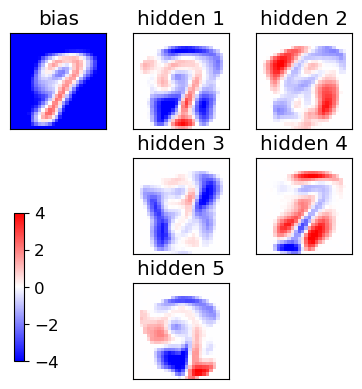

epoch 181 / 190  Nt: 2  N: 409  L: 5  rate: 0.2857142857142858  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 190  Nt: 2  N: 413  L: 5  rate: 0.28174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 190  Nt: 2  N: 418  L: 5  rate: 0.2777777777777778  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 190  Nt: 2  N: 422  L: 5  rate: 0.27380952380952384  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 190  Nt: 2  N: 427  L: 5  rate: 0.2698412698412699  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 190  Nt: 2  N: 431  L: 5  rate: 0.2658730158730158  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 190  Nt: 2  N: 436  L: 5  rate: 0.261904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 190  Nt: 2  N: 440  L: 5  rate: 0.2579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 190  Nt: 2  N: 445  L: 5  rate: 0.25396825396825395  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 190  Nt: 2  N: 450  L: 5  rate: 0.25  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

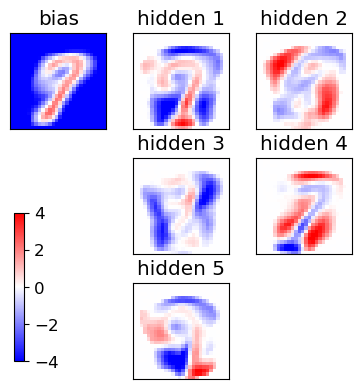

END of learning phase
Nepoch=190
Nmini=45


<Figure size 640x480 with 0 Axes>

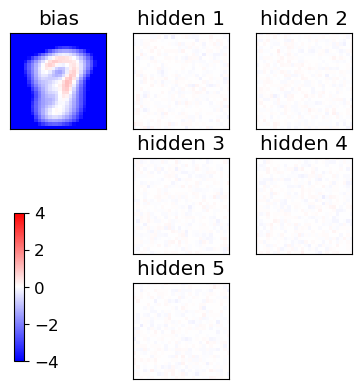

Starting the training
[ 6391  4224  6657 14341 18900 17620 20727 14480 14565 18007]
[ 3146 11650 12186  7713  1216 18072 10774  7912  4081  6545]
[15655  7119 12589  5326 12703 18921 12219  7744  9931  1886]
[18109 18037 16207 12479  2445 10826 12679 16000 15215 10834]
epoch 1 / 190  Nt: 2  N: 10  L: 5  rate: 1.0  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 190  Nt: 2  N: 10  L: 5  rate: 0.996031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 190  Nt: 2  N: 10  L: 5  rate: 0.9920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 190  Nt: 2  N: 10  L: 5  rate: 0.9880952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 190  Nt: 2  N: 10  L: 5  rate: 0.9841269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 190  Nt: 2  N: 10  L: 5  rate: 0.9801587301587301  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 190  Nt: 2  N: 10  L: 5  rate: 0.9761904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 190  Nt: 2  N: 10  L: 5  rate: 0.9722222222222222 

<Figure size 640x480 with 0 Axes>

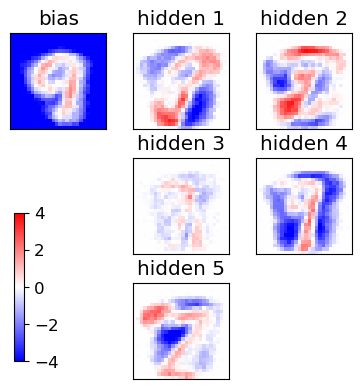

epoch 21 / 190  Nt: 2  N: 14  L: 5  rate: 0.9206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 190  Nt: 2  N: 15  L: 5  rate: 0.9166666666666666  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 190  Nt: 2  N: 15  L: 5  rate: 0.9126984126984127  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 190  Nt: 2  N: 16  L: 5  rate: 0.9087301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 190  Nt: 2  N: 17  L: 5  rate: 0.9047619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 190  Nt: 2  N: 17  L: 5  rate: 0.9007936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 190  Nt: 2  N: 18  L: 5  rate: 0.8968253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 190  Nt: 2  N: 18  L: 5  rate: 0.8928571428571429  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 190  Nt: 2  N: 19  L: 5  rate: 0.8888888888888888  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 190  Nt: 2  N: 20  L: 5  rate: 0.8849206349206349  gam: 0.001 SPINS= False POTTS= False
epoch 31 /

<Figure size 640x480 with 0 Axes>

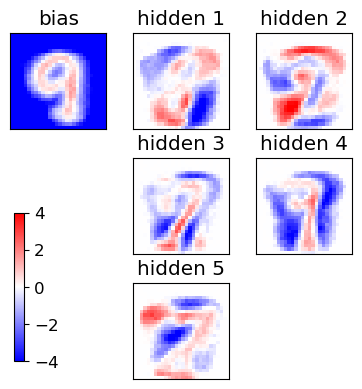

epoch 41 / 190  Nt: 2  N: 29  L: 5  rate: 0.8412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 190  Nt: 2  N: 30  L: 5  rate: 0.8373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 190  Nt: 2  N: 31  L: 5  rate: 0.8333333333333334  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 190  Nt: 2  N: 32  L: 5  rate: 0.8293650793650793  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 190  Nt: 2  N: 33  L: 5  rate: 0.8253968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 190  Nt: 2  N: 34  L: 5  rate: 0.8214285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 190  Nt: 2  N: 36  L: 5  rate: 0.8174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 190  Nt: 2  N: 37  L: 5  rate: 0.8134920634920635  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 190  Nt: 2  N: 38  L: 5  rate: 0.8095238095238095  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 190  Nt: 2  N: 39  L: 5  rate: 0.8055555555555556  gam: 0.001 SPINS= False POTTS= False
epoch 51 /

<Figure size 640x480 with 0 Axes>

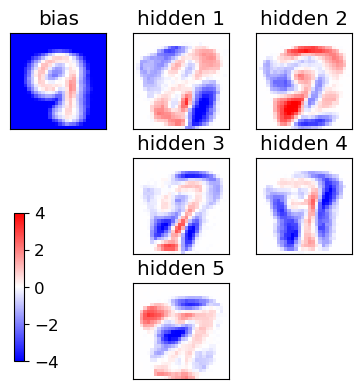

epoch 61 / 190  Nt: 2  N: 54  L: 5  rate: 0.7619047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 190  Nt: 2  N: 55  L: 5  rate: 0.7579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 190  Nt: 2  N: 57  L: 5  rate: 0.753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 190  Nt: 2  N: 58  L: 5  rate: 0.75  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 190  Nt: 2  N: 60  L: 5  rate: 0.746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 190  Nt: 2  N: 62  L: 5  rate: 0.7420634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 190  Nt: 2  N: 63  L: 5  rate: 0.7380952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 190  Nt: 2  N: 65  L: 5  rate: 0.7341269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 190  Nt: 2  N: 66  L: 5  rate: 0.7301587301587302  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 190  Nt: 2  N: 68  L: 5  rate: 0.7261904761904763  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 190  Nt: 2  N: 

<Figure size 640x480 with 0 Axes>

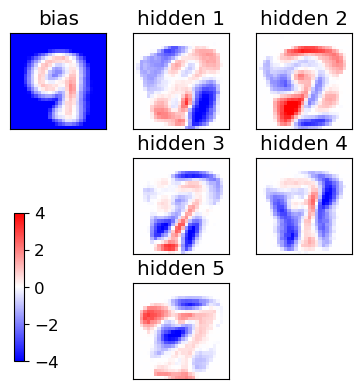

epoch 81 / 190  Nt: 2  N: 88  L: 5  rate: 0.6825396825396826  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 190  Nt: 2  N: 90  L: 5  rate: 0.6785714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 190  Nt: 2  N: 92  L: 5  rate: 0.6746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 190  Nt: 2  N: 94  L: 5  rate: 0.6706349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 190  Nt: 2  N: 96  L: 5  rate: 0.6666666666666667  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 190  Nt: 2  N: 98  L: 5  rate: 0.6626984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 190  Nt: 2  N: 101  L: 5  rate: 0.6587301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 190  Nt: 2  N: 103  L: 5  rate: 0.6547619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 190  Nt: 2  N: 105  L: 5  rate: 0.6507936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 190  Nt: 2  N: 107  L: 5  rate: 0.6468253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 

<Figure size 640x480 with 0 Axes>

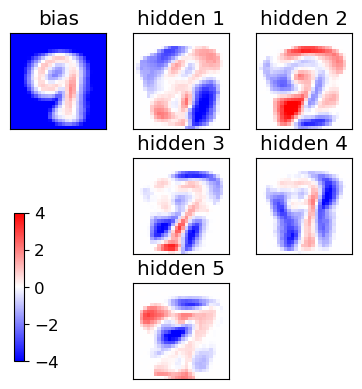

epoch 101 / 190  Nt: 2  N: 133  L: 5  rate: 0.6031746031746033  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 190  Nt: 2  N: 135  L: 5  rate: 0.5992063492063492  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 190  Nt: 2  N: 138  L: 5  rate: 0.5952380952380952  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 190  Nt: 2  N: 140  L: 5  rate: 0.5912698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 190  Nt: 2  N: 143  L: 5  rate: 0.5873015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 190  Nt: 2  N: 145  L: 5  rate: 0.5833333333333333  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 190  Nt: 2  N: 148  L: 5  rate: 0.5793650793650794  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 190  Nt: 2  N: 151  L: 5  rate: 0.5753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 190  Nt: 2  N: 153  L: 5  rate: 0.5714285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 190  Nt: 2  N: 156  L: 5  rate: 0.5674603174603174  gam: 0.001 SPINS= False POT

<Figure size 640x480 with 0 Axes>

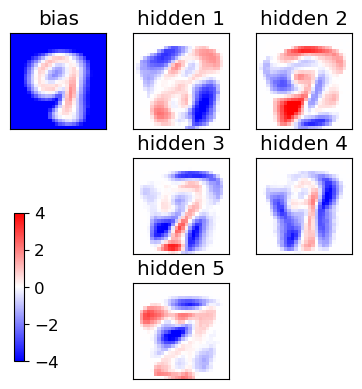

epoch 121 / 190  Nt: 2  N: 187  L: 5  rate: 0.5238095238095238  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 190  Nt: 2  N: 190  L: 5  rate: 0.5198412698412698  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 190  Nt: 2  N: 193  L: 5  rate: 0.5158730158730159  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 190  Nt: 2  N: 196  L: 5  rate: 0.5119047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 190  Nt: 2  N: 199  L: 5  rate: 0.5079365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 190  Nt: 2  N: 202  L: 5  rate: 0.503968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 190  Nt: 2  N: 205  L: 5  rate: 0.5  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 190  Nt: 2  N: 208  L: 5  rate: 0.49603174603174605  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 190  Nt: 2  N: 211  L: 5  rate: 0.4920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 190  Nt: 2  N: 214  L: 5  rate: 0.48809523809523814  gam: 0.001 SPINS= False POTTS= False
epoc

<Figure size 640x480 with 0 Axes>

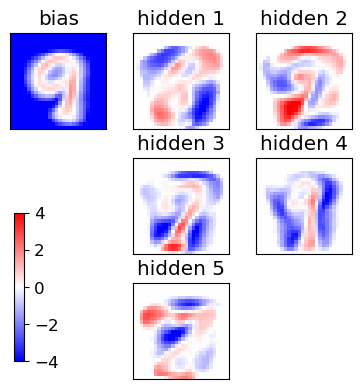

epoch 141 / 190  Nt: 2  N: 251  L: 5  rate: 0.4444444444444444  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 190  Nt: 2  N: 254  L: 5  rate: 0.44047619047619047  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 190  Nt: 2  N: 258  L: 5  rate: 0.4365079365079365  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 190  Nt: 2  N: 261  L: 5  rate: 0.43253968253968256  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 190  Nt: 2  N: 265  L: 5  rate: 0.4285714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 190  Nt: 2  N: 268  L: 5  rate: 0.42460317460317465  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 190  Nt: 2  N: 272  L: 5  rate: 0.4206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 190  Nt: 2  N: 276  L: 5  rate: 0.41666666666666663  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 190  Nt: 2  N: 279  L: 5  rate: 0.4126984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 190  Nt: 2  N: 283  L: 5  rate: 0.4087301587301587  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

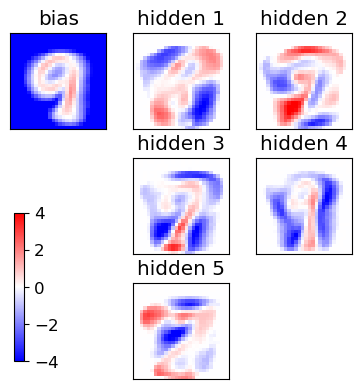

epoch 161 / 190  Nt: 2  N: 325  L: 5  rate: 0.3650793650793651  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 190  Nt: 2  N: 329  L: 5  rate: 0.36111111111111116  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 190  Nt: 2  N: 333  L: 5  rate: 0.3571428571428572  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 190  Nt: 2  N: 337  L: 5  rate: 0.35317460317460314  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 190  Nt: 2  N: 341  L: 5  rate: 0.3492063492063493  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 190  Nt: 2  N: 345  L: 5  rate: 0.34523809523809523  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 190  Nt: 2  N: 349  L: 5  rate: 0.3412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 190  Nt: 2  N: 353  L: 5  rate: 0.3373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 190  Nt: 2  N: 357  L: 5  rate: 0.33333333333333337  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 190  Nt: 2  N: 361  L: 5  rate: 0.3293650793650793  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

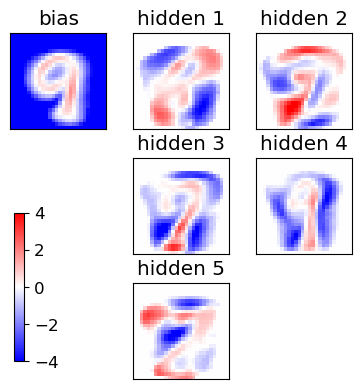

epoch 181 / 190  Nt: 2  N: 409  L: 5  rate: 0.2857142857142858  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 190  Nt: 2  N: 413  L: 5  rate: 0.28174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 190  Nt: 2  N: 418  L: 5  rate: 0.2777777777777778  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 190  Nt: 2  N: 422  L: 5  rate: 0.27380952380952384  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 190  Nt: 2  N: 427  L: 5  rate: 0.2698412698412699  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 190  Nt: 2  N: 431  L: 5  rate: 0.2658730158730158  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 190  Nt: 2  N: 436  L: 5  rate: 0.261904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 190  Nt: 2  N: 440  L: 5  rate: 0.2579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 190  Nt: 2  N: 445  L: 5  rate: 0.25396825396825395  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 190  Nt: 2  N: 450  L: 5  rate: 0.25  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

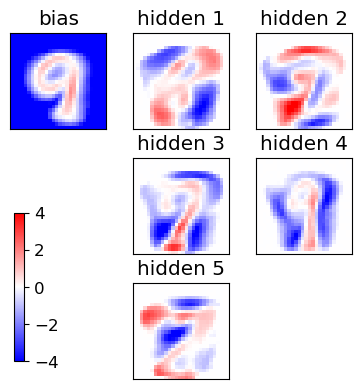

END of learning phase
Nepoch=190
Nmini=45


<Figure size 640x480 with 0 Axes>

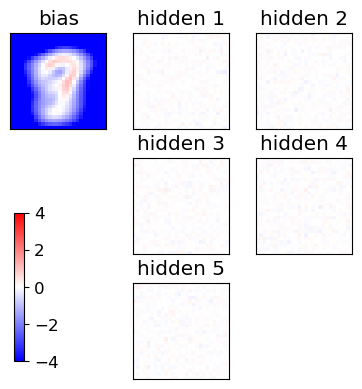

Starting the training
[ 8631 14136 19365  3479  9826 11494  9190 15925 14053 13532]
[14727  7125 18315 12145 11450 10328 14714 12034  7450 11677]
[17823 10636 17279  7647 16934  2319  6813 16757  3409  1638]
[15313  3306 20257 15908  6361  7495  8917 16867 10125 14006]
epoch 1 / 190  Nt: 2  N: 10  L: 5  rate: 1.0  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 190  Nt: 2  N: 10  L: 5  rate: 0.996031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 190  Nt: 2  N: 10  L: 5  rate: 0.9920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 190  Nt: 2  N: 10  L: 5  rate: 0.9880952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 190  Nt: 2  N: 10  L: 5  rate: 0.9841269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 190  Nt: 2  N: 10  L: 5  rate: 0.9801587301587301  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 190  Nt: 2  N: 10  L: 5  rate: 0.9761904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 190  Nt: 2  N: 10  L: 5  rate: 0.9722222222222222 

<Figure size 640x480 with 0 Axes>

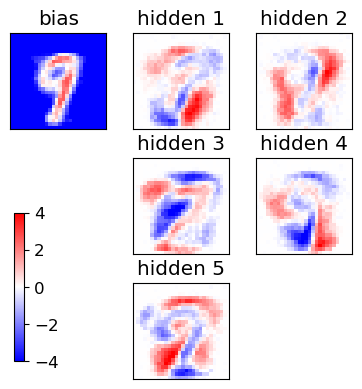

epoch 21 / 190  Nt: 2  N: 14  L: 5  rate: 0.9206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 190  Nt: 2  N: 15  L: 5  rate: 0.9166666666666666  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 190  Nt: 2  N: 15  L: 5  rate: 0.9126984126984127  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 190  Nt: 2  N: 16  L: 5  rate: 0.9087301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 190  Nt: 2  N: 17  L: 5  rate: 0.9047619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 190  Nt: 2  N: 17  L: 5  rate: 0.9007936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 190  Nt: 2  N: 18  L: 5  rate: 0.8968253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 190  Nt: 2  N: 18  L: 5  rate: 0.8928571428571429  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 190  Nt: 2  N: 19  L: 5  rate: 0.8888888888888888  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 190  Nt: 2  N: 20  L: 5  rate: 0.8849206349206349  gam: 0.001 SPINS= False POTTS= False
epoch 31 /

<Figure size 640x480 with 0 Axes>

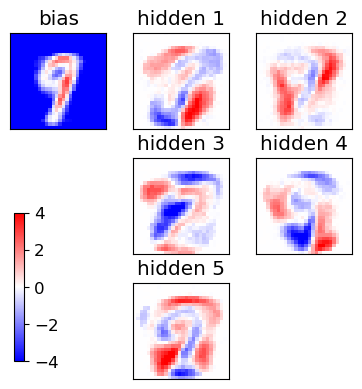

epoch 41 / 190  Nt: 2  N: 29  L: 5  rate: 0.8412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 190  Nt: 2  N: 30  L: 5  rate: 0.8373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 190  Nt: 2  N: 31  L: 5  rate: 0.8333333333333334  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 190  Nt: 2  N: 32  L: 5  rate: 0.8293650793650793  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 190  Nt: 2  N: 33  L: 5  rate: 0.8253968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 190  Nt: 2  N: 34  L: 5  rate: 0.8214285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 190  Nt: 2  N: 36  L: 5  rate: 0.8174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 190  Nt: 2  N: 37  L: 5  rate: 0.8134920634920635  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 190  Nt: 2  N: 38  L: 5  rate: 0.8095238095238095  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 190  Nt: 2  N: 39  L: 5  rate: 0.8055555555555556  gam: 0.001 SPINS= False POTTS= False
epoch 51 /

<Figure size 640x480 with 0 Axes>

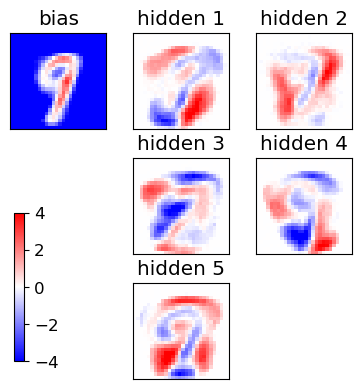

epoch 61 / 190  Nt: 2  N: 54  L: 5  rate: 0.7619047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 190  Nt: 2  N: 55  L: 5  rate: 0.7579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 190  Nt: 2  N: 57  L: 5  rate: 0.753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 190  Nt: 2  N: 58  L: 5  rate: 0.75  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 190  Nt: 2  N: 60  L: 5  rate: 0.746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 190  Nt: 2  N: 62  L: 5  rate: 0.7420634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 190  Nt: 2  N: 63  L: 5  rate: 0.7380952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 190  Nt: 2  N: 65  L: 5  rate: 0.7341269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 190  Nt: 2  N: 66  L: 5  rate: 0.7301587301587302  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 190  Nt: 2  N: 68  L: 5  rate: 0.7261904761904763  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 190  Nt: 2  N: 

<Figure size 640x480 with 0 Axes>

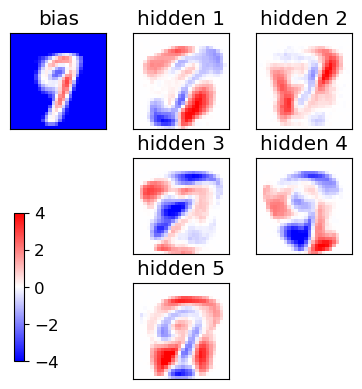

epoch 81 / 190  Nt: 2  N: 88  L: 5  rate: 0.6825396825396826  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 190  Nt: 2  N: 90  L: 5  rate: 0.6785714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 190  Nt: 2  N: 92  L: 5  rate: 0.6746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 190  Nt: 2  N: 94  L: 5  rate: 0.6706349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 190  Nt: 2  N: 96  L: 5  rate: 0.6666666666666667  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 190  Nt: 2  N: 98  L: 5  rate: 0.6626984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 190  Nt: 2  N: 101  L: 5  rate: 0.6587301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 190  Nt: 2  N: 103  L: 5  rate: 0.6547619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 190  Nt: 2  N: 105  L: 5  rate: 0.6507936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 190  Nt: 2  N: 107  L: 5  rate: 0.6468253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 

<Figure size 640x480 with 0 Axes>

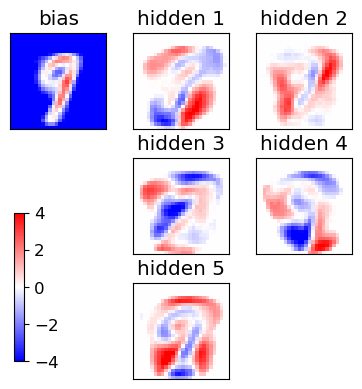

epoch 101 / 190  Nt: 2  N: 133  L: 5  rate: 0.6031746031746033  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 190  Nt: 2  N: 135  L: 5  rate: 0.5992063492063492  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 190  Nt: 2  N: 138  L: 5  rate: 0.5952380952380952  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 190  Nt: 2  N: 140  L: 5  rate: 0.5912698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 190  Nt: 2  N: 143  L: 5  rate: 0.5873015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 190  Nt: 2  N: 145  L: 5  rate: 0.5833333333333333  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 190  Nt: 2  N: 148  L: 5  rate: 0.5793650793650794  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 190  Nt: 2  N: 151  L: 5  rate: 0.5753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 190  Nt: 2  N: 153  L: 5  rate: 0.5714285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 190  Nt: 2  N: 156  L: 5  rate: 0.5674603174603174  gam: 0.001 SPINS= False POT

<Figure size 640x480 with 0 Axes>

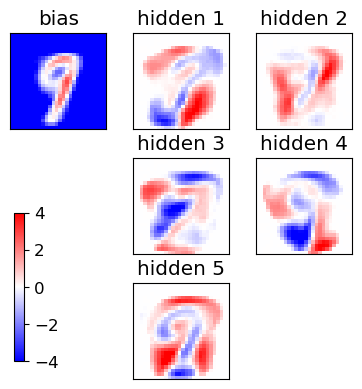

epoch 121 / 190  Nt: 2  N: 187  L: 5  rate: 0.5238095238095238  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 190  Nt: 2  N: 190  L: 5  rate: 0.5198412698412698  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 190  Nt: 2  N: 193  L: 5  rate: 0.5158730158730159  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 190  Nt: 2  N: 196  L: 5  rate: 0.5119047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 190  Nt: 2  N: 199  L: 5  rate: 0.5079365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 190  Nt: 2  N: 202  L: 5  rate: 0.503968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 190  Nt: 2  N: 205  L: 5  rate: 0.5  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 190  Nt: 2  N: 208  L: 5  rate: 0.49603174603174605  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 190  Nt: 2  N: 211  L: 5  rate: 0.4920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 190  Nt: 2  N: 214  L: 5  rate: 0.48809523809523814  gam: 0.001 SPINS= False POTTS= False
epoc

<Figure size 640x480 with 0 Axes>

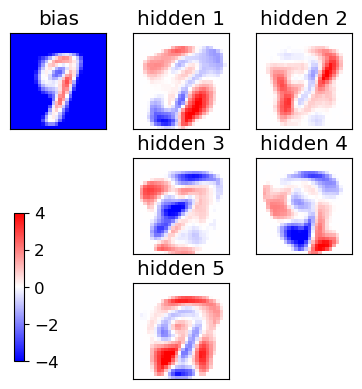

epoch 141 / 190  Nt: 2  N: 251  L: 5  rate: 0.4444444444444444  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 190  Nt: 2  N: 254  L: 5  rate: 0.44047619047619047  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 190  Nt: 2  N: 258  L: 5  rate: 0.4365079365079365  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 190  Nt: 2  N: 261  L: 5  rate: 0.43253968253968256  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 190  Nt: 2  N: 265  L: 5  rate: 0.4285714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 190  Nt: 2  N: 268  L: 5  rate: 0.42460317460317465  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 190  Nt: 2  N: 272  L: 5  rate: 0.4206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 190  Nt: 2  N: 276  L: 5  rate: 0.41666666666666663  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 190  Nt: 2  N: 279  L: 5  rate: 0.4126984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 190  Nt: 2  N: 283  L: 5  rate: 0.4087301587301587  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

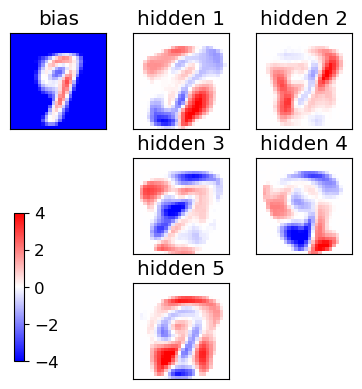

epoch 161 / 190  Nt: 2  N: 325  L: 5  rate: 0.3650793650793651  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 190  Nt: 2  N: 329  L: 5  rate: 0.36111111111111116  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 190  Nt: 2  N: 333  L: 5  rate: 0.3571428571428572  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 190  Nt: 2  N: 337  L: 5  rate: 0.35317460317460314  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 190  Nt: 2  N: 341  L: 5  rate: 0.3492063492063493  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 190  Nt: 2  N: 345  L: 5  rate: 0.34523809523809523  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 190  Nt: 2  N: 349  L: 5  rate: 0.3412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 190  Nt: 2  N: 353  L: 5  rate: 0.3373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 190  Nt: 2  N: 357  L: 5  rate: 0.33333333333333337  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 190  Nt: 2  N: 361  L: 5  rate: 0.3293650793650793  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

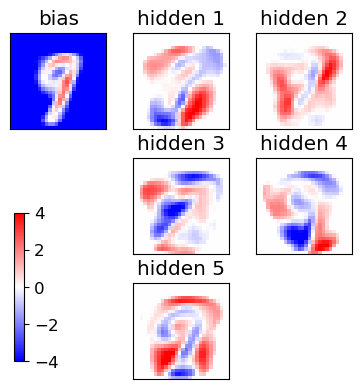

epoch 181 / 190  Nt: 2  N: 409  L: 5  rate: 0.2857142857142858  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 190  Nt: 2  N: 413  L: 5  rate: 0.28174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 190  Nt: 2  N: 418  L: 5  rate: 0.2777777777777778  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 190  Nt: 2  N: 422  L: 5  rate: 0.27380952380952384  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 190  Nt: 2  N: 427  L: 5  rate: 0.2698412698412699  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 190  Nt: 2  N: 431  L: 5  rate: 0.2658730158730158  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 190  Nt: 2  N: 436  L: 5  rate: 0.261904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 190  Nt: 2  N: 440  L: 5  rate: 0.2579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 190  Nt: 2  N: 445  L: 5  rate: 0.25396825396825395  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 190  Nt: 2  N: 450  L: 5  rate: 0.25  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

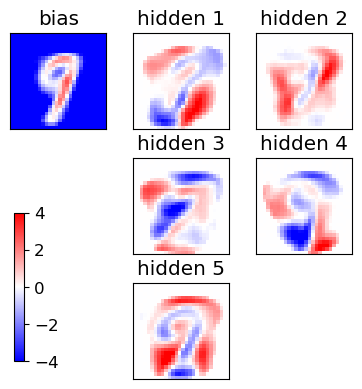

END of learning phase
Nepoch=190
Nmini=45


<Figure size 640x480 with 0 Axes>

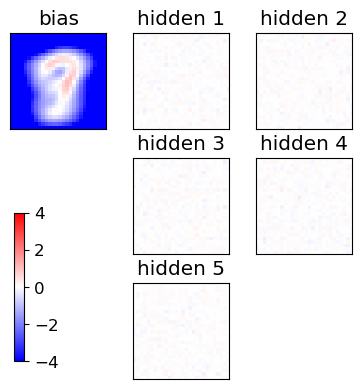

Starting the training
[ 6491  3886  3074 17240 11396  8449 14345 13555  7387  3867]
[16046  8709  4141 18967 20413  7716  9424 11366 12952  2829]
[13830  9394  2518  4903  7622   126 14284  1309  9923  4286]
[19916 15120 15076 12898 18539 19284 10322  7509 10146  7642]
epoch 1 / 190  Nt: 2  N: 10  L: 5  rate: 1.0  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 190  Nt: 2  N: 10  L: 5  rate: 0.996031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 190  Nt: 2  N: 10  L: 5  rate: 0.9920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 190  Nt: 2  N: 10  L: 5  rate: 0.9880952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 190  Nt: 2  N: 10  L: 5  rate: 0.9841269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 190  Nt: 2  N: 10  L: 5  rate: 0.9801587301587301  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 190  Nt: 2  N: 10  L: 5  rate: 0.9761904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 190  Nt: 2  N: 10  L: 5  rate: 0.9722222222222222 

<Figure size 640x480 with 0 Axes>

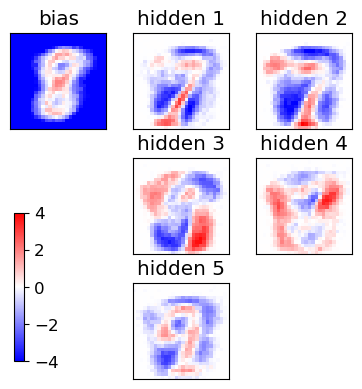

epoch 21 / 190  Nt: 2  N: 14  L: 5  rate: 0.9206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 190  Nt: 2  N: 15  L: 5  rate: 0.9166666666666666  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 190  Nt: 2  N: 15  L: 5  rate: 0.9126984126984127  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 190  Nt: 2  N: 16  L: 5  rate: 0.9087301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 190  Nt: 2  N: 17  L: 5  rate: 0.9047619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 190  Nt: 2  N: 17  L: 5  rate: 0.9007936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 190  Nt: 2  N: 18  L: 5  rate: 0.8968253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 190  Nt: 2  N: 18  L: 5  rate: 0.8928571428571429  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 190  Nt: 2  N: 19  L: 5  rate: 0.8888888888888888  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 190  Nt: 2  N: 20  L: 5  rate: 0.8849206349206349  gam: 0.001 SPINS= False POTTS= False
epoch 31 /

<Figure size 640x480 with 0 Axes>

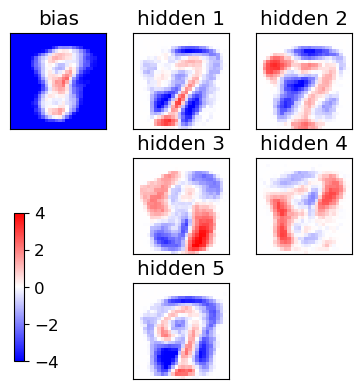

epoch 41 / 190  Nt: 2  N: 29  L: 5  rate: 0.8412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 190  Nt: 2  N: 30  L: 5  rate: 0.8373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 190  Nt: 2  N: 31  L: 5  rate: 0.8333333333333334  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 190  Nt: 2  N: 32  L: 5  rate: 0.8293650793650793  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 190  Nt: 2  N: 33  L: 5  rate: 0.8253968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 190  Nt: 2  N: 34  L: 5  rate: 0.8214285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 190  Nt: 2  N: 36  L: 5  rate: 0.8174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 190  Nt: 2  N: 37  L: 5  rate: 0.8134920634920635  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 190  Nt: 2  N: 38  L: 5  rate: 0.8095238095238095  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 190  Nt: 2  N: 39  L: 5  rate: 0.8055555555555556  gam: 0.001 SPINS= False POTTS= False
epoch 51 /

<Figure size 640x480 with 0 Axes>

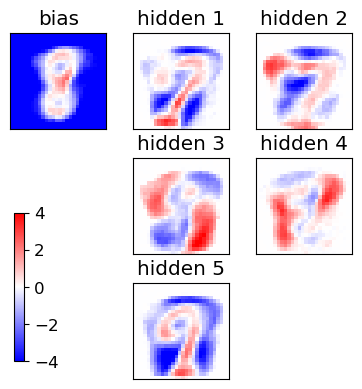

epoch 61 / 190  Nt: 2  N: 54  L: 5  rate: 0.7619047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 190  Nt: 2  N: 55  L: 5  rate: 0.7579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 190  Nt: 2  N: 57  L: 5  rate: 0.753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 190  Nt: 2  N: 58  L: 5  rate: 0.75  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 190  Nt: 2  N: 60  L: 5  rate: 0.746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 190  Nt: 2  N: 62  L: 5  rate: 0.7420634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 190  Nt: 2  N: 63  L: 5  rate: 0.7380952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 190  Nt: 2  N: 65  L: 5  rate: 0.7341269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 190  Nt: 2  N: 66  L: 5  rate: 0.7301587301587302  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 190  Nt: 2  N: 68  L: 5  rate: 0.7261904761904763  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 190  Nt: 2  N: 

<Figure size 640x480 with 0 Axes>

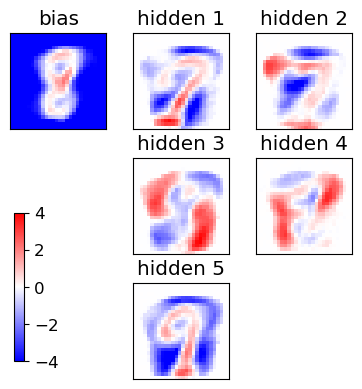

epoch 81 / 190  Nt: 2  N: 88  L: 5  rate: 0.6825396825396826  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 190  Nt: 2  N: 90  L: 5  rate: 0.6785714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 190  Nt: 2  N: 92  L: 5  rate: 0.6746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 190  Nt: 2  N: 94  L: 5  rate: 0.6706349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 190  Nt: 2  N: 96  L: 5  rate: 0.6666666666666667  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 190  Nt: 2  N: 98  L: 5  rate: 0.6626984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 190  Nt: 2  N: 101  L: 5  rate: 0.6587301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 190  Nt: 2  N: 103  L: 5  rate: 0.6547619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 190  Nt: 2  N: 105  L: 5  rate: 0.6507936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 190  Nt: 2  N: 107  L: 5  rate: 0.6468253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 

<Figure size 640x480 with 0 Axes>

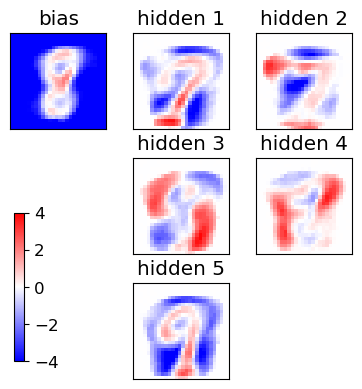

epoch 101 / 190  Nt: 2  N: 133  L: 5  rate: 0.6031746031746033  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 190  Nt: 2  N: 135  L: 5  rate: 0.5992063492063492  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 190  Nt: 2  N: 138  L: 5  rate: 0.5952380952380952  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 190  Nt: 2  N: 140  L: 5  rate: 0.5912698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 190  Nt: 2  N: 143  L: 5  rate: 0.5873015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 190  Nt: 2  N: 145  L: 5  rate: 0.5833333333333333  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 190  Nt: 2  N: 148  L: 5  rate: 0.5793650793650794  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 190  Nt: 2  N: 151  L: 5  rate: 0.5753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 190  Nt: 2  N: 153  L: 5  rate: 0.5714285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 190  Nt: 2  N: 156  L: 5  rate: 0.5674603174603174  gam: 0.001 SPINS= False POT

<Figure size 640x480 with 0 Axes>

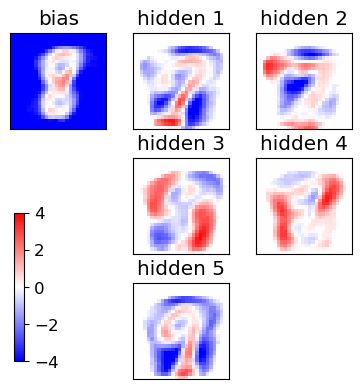

epoch 121 / 190  Nt: 2  N: 187  L: 5  rate: 0.5238095238095238  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 190  Nt: 2  N: 190  L: 5  rate: 0.5198412698412698  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 190  Nt: 2  N: 193  L: 5  rate: 0.5158730158730159  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 190  Nt: 2  N: 196  L: 5  rate: 0.5119047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 190  Nt: 2  N: 199  L: 5  rate: 0.5079365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 190  Nt: 2  N: 202  L: 5  rate: 0.503968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 190  Nt: 2  N: 205  L: 5  rate: 0.5  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 190  Nt: 2  N: 208  L: 5  rate: 0.49603174603174605  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 190  Nt: 2  N: 211  L: 5  rate: 0.4920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 190  Nt: 2  N: 214  L: 5  rate: 0.48809523809523814  gam: 0.001 SPINS= False POTTS= False
epoc

<Figure size 640x480 with 0 Axes>

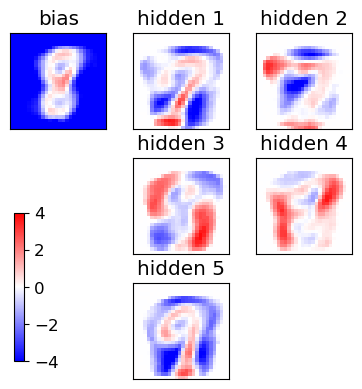

epoch 141 / 190  Nt: 2  N: 251  L: 5  rate: 0.4444444444444444  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 190  Nt: 2  N: 254  L: 5  rate: 0.44047619047619047  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 190  Nt: 2  N: 258  L: 5  rate: 0.4365079365079365  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 190  Nt: 2  N: 261  L: 5  rate: 0.43253968253968256  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 190  Nt: 2  N: 265  L: 5  rate: 0.4285714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 190  Nt: 2  N: 268  L: 5  rate: 0.42460317460317465  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 190  Nt: 2  N: 272  L: 5  rate: 0.4206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 190  Nt: 2  N: 276  L: 5  rate: 0.41666666666666663  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 190  Nt: 2  N: 279  L: 5  rate: 0.4126984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 190  Nt: 2  N: 283  L: 5  rate: 0.4087301587301587  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

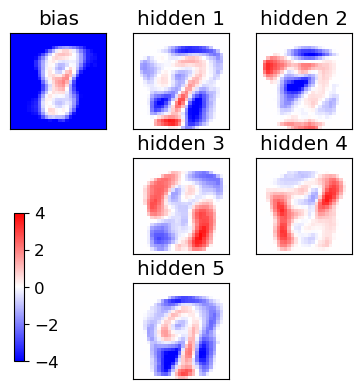

epoch 161 / 190  Nt: 2  N: 325  L: 5  rate: 0.3650793650793651  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 190  Nt: 2  N: 329  L: 5  rate: 0.36111111111111116  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 190  Nt: 2  N: 333  L: 5  rate: 0.3571428571428572  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 190  Nt: 2  N: 337  L: 5  rate: 0.35317460317460314  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 190  Nt: 2  N: 341  L: 5  rate: 0.3492063492063493  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 190  Nt: 2  N: 345  L: 5  rate: 0.34523809523809523  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 190  Nt: 2  N: 349  L: 5  rate: 0.3412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 190  Nt: 2  N: 353  L: 5  rate: 0.3373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 190  Nt: 2  N: 357  L: 5  rate: 0.33333333333333337  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 190  Nt: 2  N: 361  L: 5  rate: 0.3293650793650793  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

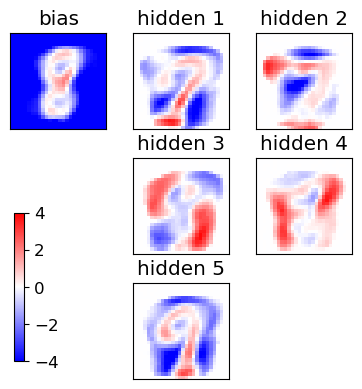

epoch 181 / 190  Nt: 2  N: 409  L: 5  rate: 0.2857142857142858  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 190  Nt: 2  N: 413  L: 5  rate: 0.28174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 190  Nt: 2  N: 418  L: 5  rate: 0.2777777777777778  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 190  Nt: 2  N: 422  L: 5  rate: 0.27380952380952384  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 190  Nt: 2  N: 427  L: 5  rate: 0.2698412698412699  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 190  Nt: 2  N: 431  L: 5  rate: 0.2658730158730158  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 190  Nt: 2  N: 436  L: 5  rate: 0.261904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 190  Nt: 2  N: 440  L: 5  rate: 0.2579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 190  Nt: 2  N: 445  L: 5  rate: 0.25396825396825395  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 190  Nt: 2  N: 450  L: 5  rate: 0.25  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

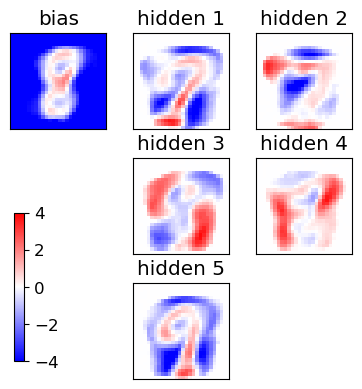

END of learning phase
Nepoch=190
Nmini=45


<Figure size 640x480 with 0 Axes>

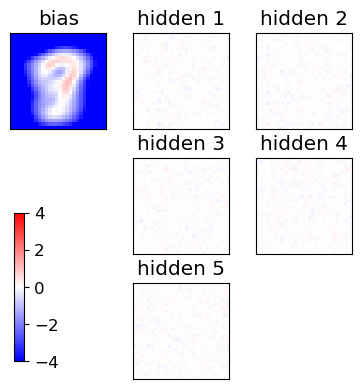

Starting the training
[ 2678  9791 15299   783  3989 17538 19088 17264  5318 14856]
[17313  1130  9907 12038 19776 14010  4830 15828  4226  8344]
[18487 14493  9825 17302  2789  8570  3002  6064 20059 11312]
[17145 20150  3203  3398  9509  9143  5188  8101 19454 15616]
epoch 1 / 190  Nt: 2  N: 10  L: 5  rate: 1.0  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 190  Nt: 2  N: 10  L: 5  rate: 0.996031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 190  Nt: 2  N: 10  L: 5  rate: 0.9920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 190  Nt: 2  N: 10  L: 5  rate: 0.9880952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 190  Nt: 2  N: 10  L: 5  rate: 0.9841269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 190  Nt: 2  N: 10  L: 5  rate: 0.9801587301587301  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 190  Nt: 2  N: 10  L: 5  rate: 0.9761904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 190  Nt: 2  N: 10  L: 5  rate: 0.9722222222222222 

<Figure size 640x480 with 0 Axes>

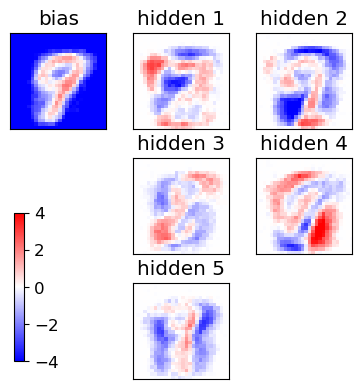

epoch 21 / 190  Nt: 2  N: 14  L: 5  rate: 0.9206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 190  Nt: 2  N: 15  L: 5  rate: 0.9166666666666666  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 190  Nt: 2  N: 15  L: 5  rate: 0.9126984126984127  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 190  Nt: 2  N: 16  L: 5  rate: 0.9087301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 190  Nt: 2  N: 17  L: 5  rate: 0.9047619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 190  Nt: 2  N: 17  L: 5  rate: 0.9007936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 190  Nt: 2  N: 18  L: 5  rate: 0.8968253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 190  Nt: 2  N: 18  L: 5  rate: 0.8928571428571429  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 190  Nt: 2  N: 19  L: 5  rate: 0.8888888888888888  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 190  Nt: 2  N: 20  L: 5  rate: 0.8849206349206349  gam: 0.001 SPINS= False POTTS= False
epoch 31 /

<Figure size 640x480 with 0 Axes>

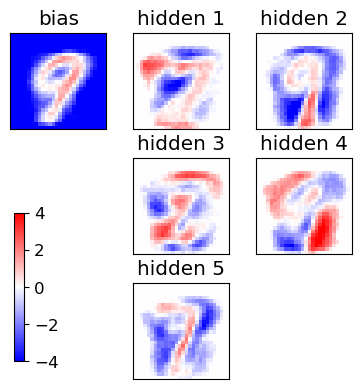

epoch 41 / 190  Nt: 2  N: 29  L: 5  rate: 0.8412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 190  Nt: 2  N: 30  L: 5  rate: 0.8373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 190  Nt: 2  N: 31  L: 5  rate: 0.8333333333333334  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 190  Nt: 2  N: 32  L: 5  rate: 0.8293650793650793  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 190  Nt: 2  N: 33  L: 5  rate: 0.8253968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 190  Nt: 2  N: 34  L: 5  rate: 0.8214285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 190  Nt: 2  N: 36  L: 5  rate: 0.8174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 190  Nt: 2  N: 37  L: 5  rate: 0.8134920634920635  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 190  Nt: 2  N: 38  L: 5  rate: 0.8095238095238095  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 190  Nt: 2  N: 39  L: 5  rate: 0.8055555555555556  gam: 0.001 SPINS= False POTTS= False
epoch 51 /

<Figure size 640x480 with 0 Axes>

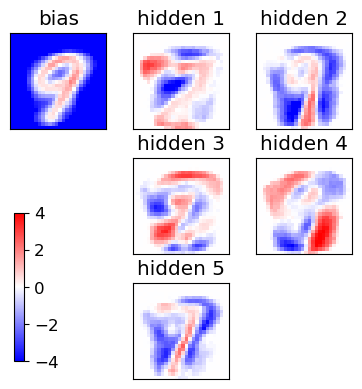

epoch 61 / 190  Nt: 2  N: 54  L: 5  rate: 0.7619047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 190  Nt: 2  N: 55  L: 5  rate: 0.7579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 190  Nt: 2  N: 57  L: 5  rate: 0.753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 190  Nt: 2  N: 58  L: 5  rate: 0.75  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 190  Nt: 2  N: 60  L: 5  rate: 0.746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 190  Nt: 2  N: 62  L: 5  rate: 0.7420634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 190  Nt: 2  N: 63  L: 5  rate: 0.7380952380952381  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 190  Nt: 2  N: 65  L: 5  rate: 0.7341269841269842  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 190  Nt: 2  N: 66  L: 5  rate: 0.7301587301587302  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 190  Nt: 2  N: 68  L: 5  rate: 0.7261904761904763  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 190  Nt: 2  N: 

<Figure size 640x480 with 0 Axes>

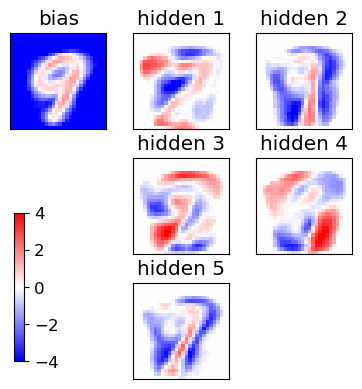

epoch 81 / 190  Nt: 2  N: 88  L: 5  rate: 0.6825396825396826  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 190  Nt: 2  N: 90  L: 5  rate: 0.6785714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 190  Nt: 2  N: 92  L: 5  rate: 0.6746031746031746  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 190  Nt: 2  N: 94  L: 5  rate: 0.6706349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 190  Nt: 2  N: 96  L: 5  rate: 0.6666666666666667  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 190  Nt: 2  N: 98  L: 5  rate: 0.6626984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 190  Nt: 2  N: 101  L: 5  rate: 0.6587301587301587  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 190  Nt: 2  N: 103  L: 5  rate: 0.6547619047619048  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 190  Nt: 2  N: 105  L: 5  rate: 0.6507936507936508  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 190  Nt: 2  N: 107  L: 5  rate: 0.6468253968253969  gam: 0.001 SPINS= False POTTS= False
epoch 

<Figure size 640x480 with 0 Axes>

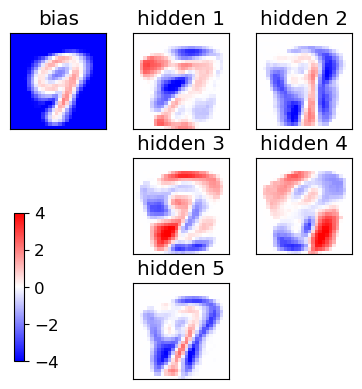

epoch 101 / 190  Nt: 2  N: 133  L: 5  rate: 0.6031746031746033  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 190  Nt: 2  N: 135  L: 5  rate: 0.5992063492063492  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 190  Nt: 2  N: 138  L: 5  rate: 0.5952380952380952  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 190  Nt: 2  N: 140  L: 5  rate: 0.5912698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 190  Nt: 2  N: 143  L: 5  rate: 0.5873015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 190  Nt: 2  N: 145  L: 5  rate: 0.5833333333333333  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 190  Nt: 2  N: 148  L: 5  rate: 0.5793650793650794  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 190  Nt: 2  N: 151  L: 5  rate: 0.5753968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 190  Nt: 2  N: 153  L: 5  rate: 0.5714285714285714  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 190  Nt: 2  N: 156  L: 5  rate: 0.5674603174603174  gam: 0.001 SPINS= False POT

<Figure size 640x480 with 0 Axes>

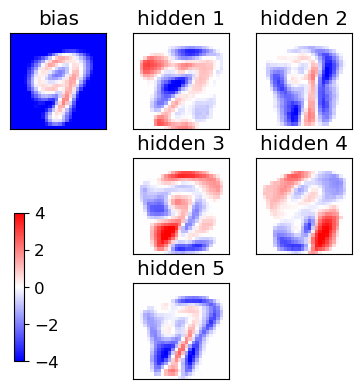

epoch 121 / 190  Nt: 2  N: 187  L: 5  rate: 0.5238095238095238  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 190  Nt: 2  N: 190  L: 5  rate: 0.5198412698412698  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 190  Nt: 2  N: 193  L: 5  rate: 0.5158730158730159  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 190  Nt: 2  N: 196  L: 5  rate: 0.5119047619047619  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 190  Nt: 2  N: 199  L: 5  rate: 0.5079365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 190  Nt: 2  N: 202  L: 5  rate: 0.503968253968254  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 190  Nt: 2  N: 205  L: 5  rate: 0.5  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 190  Nt: 2  N: 208  L: 5  rate: 0.49603174603174605  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 190  Nt: 2  N: 211  L: 5  rate: 0.4920634920634921  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 190  Nt: 2  N: 214  L: 5  rate: 0.48809523809523814  gam: 0.001 SPINS= False POTTS= False
epoc

<Figure size 640x480 with 0 Axes>

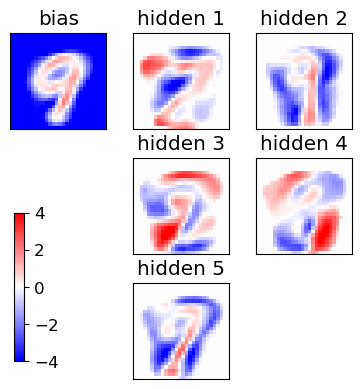

epoch 141 / 190  Nt: 2  N: 251  L: 5  rate: 0.4444444444444444  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 190  Nt: 2  N: 254  L: 5  rate: 0.44047619047619047  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 190  Nt: 2  N: 258  L: 5  rate: 0.4365079365079365  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 190  Nt: 2  N: 261  L: 5  rate: 0.43253968253968256  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 190  Nt: 2  N: 265  L: 5  rate: 0.4285714285714286  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 190  Nt: 2  N: 268  L: 5  rate: 0.42460317460317465  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 190  Nt: 2  N: 272  L: 5  rate: 0.4206349206349207  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 190  Nt: 2  N: 276  L: 5  rate: 0.41666666666666663  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 190  Nt: 2  N: 279  L: 5  rate: 0.4126984126984128  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 190  Nt: 2  N: 283  L: 5  rate: 0.4087301587301587  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

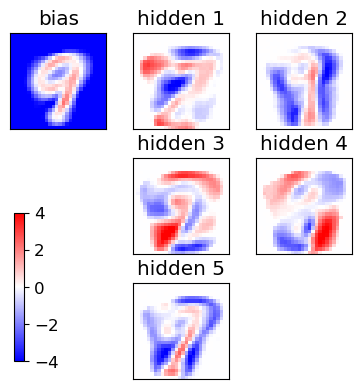

epoch 161 / 190  Nt: 2  N: 325  L: 5  rate: 0.3650793650793651  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 190  Nt: 2  N: 329  L: 5  rate: 0.36111111111111116  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 190  Nt: 2  N: 333  L: 5  rate: 0.3571428571428572  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 190  Nt: 2  N: 337  L: 5  rate: 0.35317460317460314  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 190  Nt: 2  N: 341  L: 5  rate: 0.3492063492063493  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 190  Nt: 2  N: 345  L: 5  rate: 0.34523809523809523  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 190  Nt: 2  N: 349  L: 5  rate: 0.3412698412698413  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 190  Nt: 2  N: 353  L: 5  rate: 0.3373015873015873  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 190  Nt: 2  N: 357  L: 5  rate: 0.33333333333333337  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 190  Nt: 2  N: 361  L: 5  rate: 0.3293650793650793  gam: 0.001 SPINS= False

<Figure size 640x480 with 0 Axes>

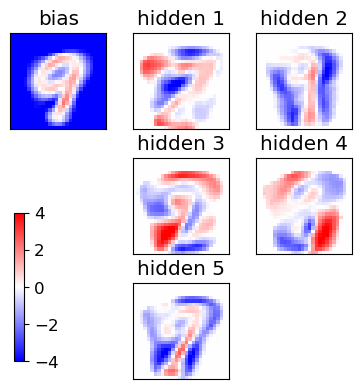

epoch 181 / 190  Nt: 2  N: 409  L: 5  rate: 0.2857142857142858  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 190  Nt: 2  N: 413  L: 5  rate: 0.28174603174603174  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 190  Nt: 2  N: 418  L: 5  rate: 0.2777777777777778  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 190  Nt: 2  N: 422  L: 5  rate: 0.27380952380952384  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 190  Nt: 2  N: 427  L: 5  rate: 0.2698412698412699  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 190  Nt: 2  N: 431  L: 5  rate: 0.2658730158730158  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 190  Nt: 2  N: 436  L: 5  rate: 0.261904761904762  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 190  Nt: 2  N: 440  L: 5  rate: 0.2579365079365079  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 190  Nt: 2  N: 445  L: 5  rate: 0.25396825396825395  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 190  Nt: 2  N: 450  L: 5  rate: 0.25  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

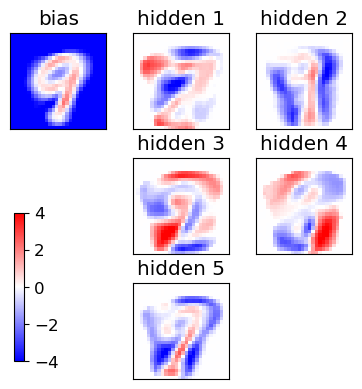

END of learning phase


In [25]:
for seed in [1, 12, 123, 1234, 12345, 123457]:
    (rdseed := np.random.seed(seed))
    ## INitial things ---> sigma tuning also??
    
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(D,L)
    #a = sigma * np.random.randn(D)
    # using Hinton initialization of visible biases
    a = Hinton_bias_init(data)
    # hidden biases initialized to zero
    b = np.zeros(L)
    print(f"Nepoch={Nepoch}\nNmini={Nmini}")
    # recording history of weights ("E" means epoch)
    wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L)) 
    wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
    gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
    gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
    gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
    miniE = np.zeros(Nepoch+1)
    pzE=np.zeros((Nepoch+1,Nz))
    
    if GRAD=="RMSprop": 
        gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    
    indices=np.arange(Nd).astype("int")
    plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
    
    # for the plot with panels
    Ncols=min(8,max(2,L//2))
    
    if POTTS: print("Starting the training, POTTS=True")
    else: print("Starting the training")
    #for L in np.arange(4,9,1):
    
    configurations = generate_configurations(L)
    log_likelihoods = []
    lista_epoch_grafico = []
    # Note: here an epoch does not analyze the whole dataset
    for epoch in range(1,1+Nepoch):
        # q maps epochs to interval [0,1]
        q = (epoch-1.)/(Nepoch-1.) 
        # N, size of the mini batch
        # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
        N = int(N_ini + (N_fin-N_ini)*(q**2))
        #  l_rate interpolates between initial and final value
        l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q
    
        for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
    
            # Minibatch of size N: points randomply picked (without repetition) from data
            selected = np.random.choice(indices,N,replace=False)
            if epoch==1 and mini<=3: print(selected)
    
            for k in range(N):
                ###################################
                x0 = data[selected[k]]
                # positive CD phase: generating z from x[k]
                z = CD_step(x0,w,b,POTTS=POTTS)
                x_data  += x0
                z_data  += z
                xz_data += np.outer(x0,z)
                # fantasy
                zf=np.copy(z)
                # Contrastive divergence with Nt steps
                for t in range(Nt):
                    # negative CD pzase: generating fantasy xf from fantasy zf
                    xf = CD_step(zf,w.T,a)
                    # positive CD phase: generating fantasy zf from fantasy xf 
                    zf = CD_step(xf,w,b,POTTS=POTTS)
                x_model += xf
                z_model += zf
                xz_model+= np.outer(xf,zf)
                # recording probability of encoding in z-space, if POTTS
                if POTTS: pz[zf]+=1
                ###################################
    
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)
    
            # gradient ascent step
            if GRAD=="RMSprop":
                # RMSprop gradient ascent
                gw2 = beta*gw2+(1-beta)*np.square(gw)
                ga2 = beta*ga2+(1-beta)*np.square(ga)
                gb2 = beta*gb2+(1-beta)*np.square(gb)
                w += l_rate*gw/sqrt(epsilon+gw2)
                a += l_rate*ga/sqrt(epsilon+ga2)
                b += l_rate*gb/sqrt(epsilon+gb2)
            else: 
                # defaulting to the vanilla stochastic gradient ascent (SGD)
                w += l_rate*gw
                a += l_rate*ga
                b += l_rate*gb
            # regularization (LASSO)
            if gamma>0.:
                w -= (gamma*l_rate)*sign(w)
                a -= (gamma*l_rate)*sign(a)
                b -= (gamma*l_rate)*sign(b)
    
        wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
        aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
        bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
        miniE[epoch]=N
        if POTTS: pzE[epoch] = pz/np.sum(pz)
        print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
              " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
    
        if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
            plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
    
        if epoch==(Nepoch):
            partition = partition_function(configurations)
            log_likelihood = compute_log_likelihood(partition,data, a=a, b=b, w=w,)
            with open(f'llh{int(code)}.txt', 'a') as add:
                print(log_likelihood, file=add)
        str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")
    print("END of learning phase")

In [34]:
loading_list = []
new_list = []
with os.scandir() as files:
    for file in files:
        if file.name.startswith('llh') and file.name.endswith('.txt'):
            loading_list.append(np.loadtxt(file.name, skiprows=2))
            new_list.append(np.genfromtxt(file.name, skip_footer=9))
loading_list
new_list

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

## Test generative power of the trained RBM

<Figure size 640x480 with 0 Axes>

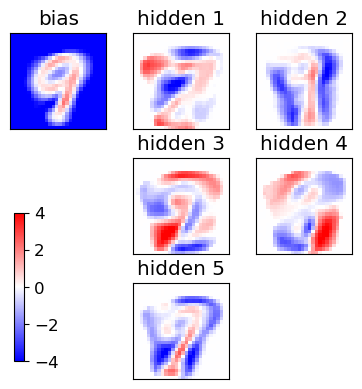

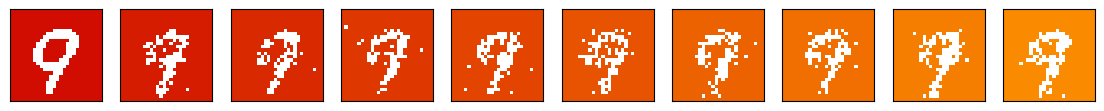

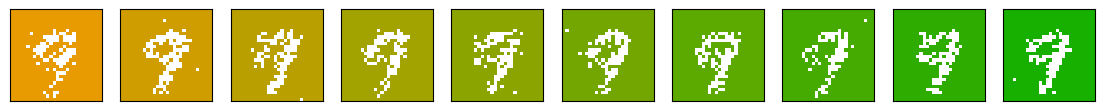

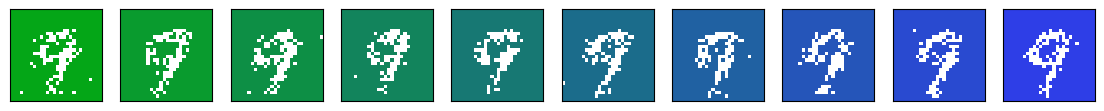

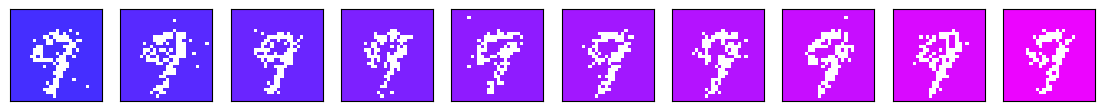

L: 5     amplification of weights: 1.0


In [26]:
ee=-1 ##
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

NE= 100


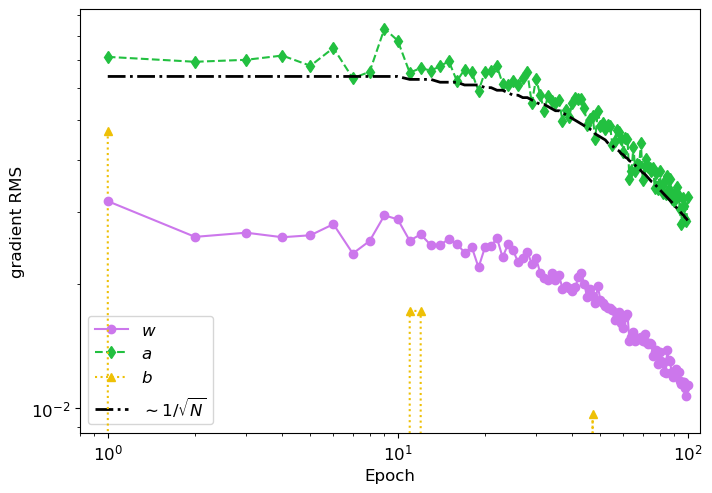

FIG/RBM_grad_MNIST3_E100_N30-150_RMSprop-0.05-0.05_CD-1_L7_reg0.01.png


In [75]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\\sim 1 / \\sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Save weights over epochs on file

In [76]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

WEIGHTS/w_RBM_Potts_MNIST3_L7_RMSprop-0.05-0.05_Ep100_reg0.01_POTTS_20250320_1724.npy
WEIGHTS/b_RBM_Potts_MNIST3_L7_RMSprop-0.05-0.05_Ep100_reg0.01_POTTS_20250320_1724.npy
WEIGHTS/a_RBM_Potts_MNIST3_L7_RMSprop-0.05-0.05_Ep100_reg0.01_POTTS_20250320_1724.npy


# RESULTS

#### 1. Initialization of biases

Explain the initialization of visible biases proposed by Hinton.

In [23]:
import os
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

# Path to your images
folder_path = "img/"
files = [(f, os.path.getmtime(os.path.join(folder_path, f))) for f in os.listdir(folder_path)] #add thing that selects just .png
# Sort files by modification time (oldest first)
files_sorted = sorted(files, key=lambda x: x[1])

# Extract sorted file names
sorted_filenames = [f[0] for f in files_sorted]
sorted_filenames = sorted_filenames[:-2]


row,cols = 5,6
fig,axes = plt.subplots(row,cols, figsize=(15,10))
axes = axes.flatten()
for i, img in enumerate(sorted_filenames[:row*cols]):
    image = Image.open('img/' +img)
    axes[i].imshow(image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

IsADirectoryError: [Errno 21] Is a directory: '/home/gigi/LCP-B/ex2/img/digit012'

#### 2. Log-likelihood

Take an RBM with L=3 hidden units and compute the log-likelihood L of data during training (see the notes). Does it grow during training? Does it depend on the number of contrastive divergence steps?  Then compare the log-likelihood L at the end of training for L=3, 4, 5, 6, … up to a maximum L of your choice.

We trained the RBM on digits 7,8,9, trying with number of hidden units L $\in [3,4,5,6,7]$, and for each value we tried different CD steps, $Nt \in [2,4,6,8,10,12]$.

Log-likelihood generally increases during training, what you can see in the resume above are graphs of the LL taken every 5 epochs to spare us computational time and get as soon as possible an overview.

What we see is that number of CD steps matters a little bit in LL increase, 2-3 points, and it depends more on the number of hidden units. Best final values are for L=7. It is interesting to see that sometimes LL stalls after a initial steep increase. We hope to find an explanation during phase of hyperparameter tuning.




cross validation: fixed hyperparameters, and multiple runs w/ different random seeds. and then mean and std of final LLH